In [1]:
import numpy
from scipy.spatial.distance import cdist
from scipy.interpolate import griddata
from time import sleep

import matplotlib.pyplot as plt

%matplotlib inline

In [15]:
class DummySensor:
    
    def __init__(self, width=512, height=424, depth_limits=(80,100), points_n=5, points_distance=20, alteration_strength=0.1, random_seed=None):
        
        #alteration_strength: 0 to 1 (maximum 1 equals numpy.pi/2 on depth range)
        
        self.width = width
        self.height = height
        self.depth_lim = depth_limits
        self.n = points_n
        self.distance = points_distance
        self.strength = alteration_strength
        self.seed = random_seed
        
        # create grid, init values, and init interpolation
        self.grid = self.create_grid()
        self.positions = self.pick_positions()
        
        self.os_values = None
        self.values = None
        self.pick_values()
        
        self.interpolation = None
        self.interpolate()
        
    ## Methods
    
    def get_frame(self):
        # TODO: Add time check for 1/30sec
        self.alter_values()
        self.interpolate()
        return self.interpolation
    
    def get_filtered_frame(self):
        return self.get_frame()        
        
    ## Private functions
    #TODO: Make private
    
    def oscillating_depth(self, random):
        r = (self.depth_lim[1] - self.depth_lim[0]) / 2
        return numpy.sin(random) * r + r + self.depth_lim[0]
    
    def create_grid(self):
        # creates 2D grid for given resolution
        x, y = numpy.meshgrid(numpy.arange(0,self.width,1), numpy.arange(0,self.height,1))
        return numpy.stack((x.ravel(),y.ravel())).T
    
    def pick_positions(self, corners=True, seed=None):
        '''
        grid: Set of possible points to pick from
        n: desired number of points, not guaranteed to be reached
        distance: distance or range, pilot points should be away from dat points
        '''
    
        numpy.random.seed(seed=seed)
    
        gl = self.grid.shape[0]
        gw = self.grid.shape[1]
        points = numpy.zeros((self.n, gw))
    
        # randomly pick initial point
        ipos = numpy.random.randint(0, gl)
        points[0, :2] = self.grid[ipos, :2]
    
        i = 1  # counter
        while i < self.n:
    
            # calculate all distances between remaining candidates and sim points
            dist = cdist(points[:i, :2], self.grid[:, :2])
            # choose candidates which are out of range
            mm = numpy.min(dist, axis=0)
            candidates = self.grid[mm > self.distance]
            # count candidates
            cl = candidates.shape[0]
            if cl < 1: break
            # randomly pick candidate and set next pilot point
            pos = numpy.random.randint(0, cl)
            points[i, :2] = candidates[pos, :2]
    
            i += 1
    
        # just return valid points if early break occured
        points = points[:i]
        
        if corners:
            c = numpy.zeros((4, gw))
            c[1,0] = self.grid[:,0].max()
            c[2,1] = self.grid[:,1].max()
            c[3,0] = self.grid[:,0].max()
            c[3,1] = self.grid[:,1].max()
            points = numpy.vstack((c, points))
    
        return points
    
    def pick_values(self):
        numpy.random.seed(seed=self.seed)
        n = self.positions.shape[0]
        self.os_values = numpy.random.uniform(-numpy.pi, numpy.pi, n)
        self.values = self.oscillating_depth(self.os_values)
    
    def alter_values(self):
        # maximum range in both directions the values should be altered
        # TODO: replace by some kind of oscillation :)
        numpy.random.seed(seed=self.seed)
        os_range = self.strength * (numpy.pi/2)
        for i, value in enumerate(self.os_values):
            self.os_values[i] = value + numpy.random.uniform(-os_range, os_range)
        self.values = self.oscillating_depth(self.os_values)
            
    def interpolate(self):
        inter = griddata(self.positions[:,:2], self.values, self.grid[:,:2], method='cubic', fill_value=0)
        self.interpolation = inter.reshape(self.height, self.width)

In [35]:
dummy = DummySensor(alteration_strength=0.1)

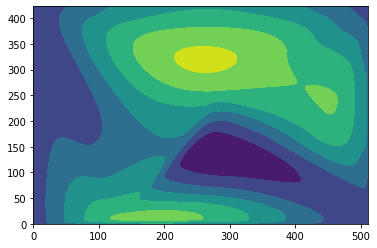

In [39]:
plt.contourf(dummy.get_frame())

(0, 300)

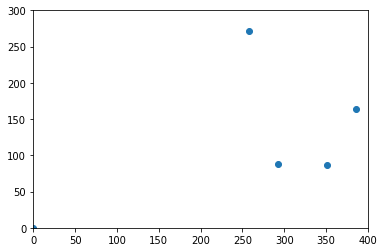

In [155]:
plt.scatter(dummy.positions[:,0],dummy.positions[:,1])
plt.xlim(0,width)
plt.ylim(0,height)

In [40]:
dummy.grid

array([[  0,   0],
       [  1,   0],
       [  2,   0],
       ...,
       [509, 423],
       [510, 423],
       [511, 423]])

In [41]:
dummy.positions

array([[  0.,   0.],
       [511.,   0.],
       [  0., 423.],
       [511., 423.],
       [441., 196.],
       [287., 179.],
       [277., 255.],
       [505.,  66.],
       [133.,  15.]])

In [42]:
dummy.values

array([81.02139882, 80.24090256, 80.01204885, 81.59239077, 94.95409331,
       80.00097474, 95.42047386, 83.76640634, 96.56288901])

In [43]:
dummy.alter_values()

In [44]:
dummy.values

array([81.70624089, 80.05357706, 80.00026972, 81.11700406, 94.99800399,
       80.04089118, 95.8254929 , 83.02779613, 97.15885889])

In [47]:
#sleep(1)

In [49]:
%%timeit
dummy.get_frame()

86.9 ms ± 552 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
plt.me
dummy.get_frame()

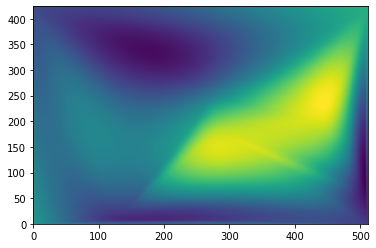

In [54]:
plt.pcolormesh(dummy.get_frame())

In [ ]:
plt.contour()